# To Oversample or Undersample?
_An analysis of sampling techniques and their effect on the prediction quality of classification modelling._

## Agenda

### [1.) Managerial Summary](#MAN)
### [2.) Setup](#Setup)
- ####  [2.1) Libraries used](#Lib)
- ####  [2.2) Data summaries](#sum)
- ####  [2.3) Irrelevant variables](#irr)
### [3.) Exploratory data analysis](#EDA)
- ####  [3.1) Attrition Count by Business Travel](#att)
- ####  [3.2) Monthly income per Department and Role ](#inc)
### [4.) Class Imbalance](#cib)
- ####  [4.1) Variable Encoding](#vinc)
- ####  [4.2) Train-test split ](#tts)
- ####  [4.3) Resampling visualization](#rsviz)
- - ####  [4.3.1)  The Random Oversampler ](#RO)
- - ####  [4.3.2)  The Random Undersampler](#RU)
- - ####  [4.3.3)  ADASYN ](#ADA)
- - ####  [4.3.4)  SMOTE ](#SMOTE)
- - ####  [4.3.5)  Edited Nearest Neighbours](#ENN)
- - ####  [4.3.6)  SMOTE ENN ](#SENN)
- - ####  [4.3.7)  Tomek Links ](#TOM)
- - ####  [4.3.8)  SMOTE Tomek](#STOM)
- - ####  [4.3.9)  Cluster Centroids ](#CC)
- - ####  [4.3.10) Near Miss ](#NM)
### [5.) Model Building and Evaluation](#MBE)
- ####  [5.1) Estimator(s) and cross-validation](#CV)
- ####  [5.2) Estimator Output](#ESTOUT)
- ####  [5.3) AUC Evaluation](#AUC)
- ####  [5.4) Accuracy Evaluation](#ACC)
- ####  [5.5) Precision Evaluation](#PCC)
- ####  [5.6) Recall Evaluation](#RCC)
### [6.) Conclusion](#FIN)

<a id="MAN"></a>
## Managerial Summary

The analysis has three primary objectives. First, it aims to predict employee attrition by determining whether an employee will churn. Second, it investigates various techniques to address the challenge of working with an unbalanced dataset. Lastly, it evaluates the impact of different sampling methods on prediction quality by testing various algorithms.
It was found that different methods of sampling can indeed either enhance the performance of an estimator or destroy it. As such, great care needs to be taken to understand and expariment with different sampling options, as well as different algorithms.

<a id="Setup"></a>
## Setup

<a id="Lib"></a>

- #### 1.1) Libraries used

In [5]:
#libraries used
import pandas as pd
import numpy as np
from IPython.display import display #makes the output is dependent on the order called
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import ClusterCentroids, NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import ADASYN
import seaborn as sns
import matplotlib.pyplot as plt


df=pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")




<a id="sum"></a>
- #### 1.2) Data summaries

The dataset comprises multiple variables, including employee demographics, compensation details, department information, and tenure within the company. It is important to mention that the observations do not seem to have any missing values, or at least no explicit null codes have been detected.

In [6]:
#Summaries
pd.set_option('display.max_columns', None) #makes sure all columns are displayed

print("Info")
display(df.info())

print("Head")
display(df.head())

print("Describe")
display(df.describe().T)

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel           

None

Head


Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
0                        2  Female          94               3         2   
1                        3    Male          61               2         2   
2                        4    Male          92               2         1   
3                        4  Female          56               3         1   
4                        1    Male          40               3         1   

                 JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  \
0        Sales Executive                4        Single           5993   
1     Research Scientist                2       Married           5130   
2  Laboratory Technician                3        Single           2090   
3     Research Scientist                3       Married           2909   
4  Laboratory Technician                2       Married           3468   

   MonthlyRate  NumCompaniesWorked Over18 OverTime  PercentSalaryHike  \
0        19479                   8      Y      Yes                 11   
1        24907                   1      Y       No                 23   
2         2396                   6      Y      Yes                 15   
3        23159                   1      Y      Yes                 11   
4        16632                   9      Y       No                 12   

   PerformanceRating  RelationshipSatisfaction  StandardHours  \
0                  3                         1             80   
1                  4                         4             80   
2                  3                         2             80   
3                  3                         3             80   
4                  3                         4             80   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
0                 0                  8                      0   
1                 1                 10                      3   
2                 0                  7                      3   
3                 0                  8                      3   
4                 1                  6                      3   

   WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                1               6                   4   
1                3              10                   7   
2                3               0                   0   
3                3               8                   7   
4                3               2                   2   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        0                     5  
1                        1                     7  
2                        0                     0  
3                        3                     0  
4                        2                     2

Describe


count          mean          std     min      25%  \
Age                       1470.0     36.923810     9.135373    18.0    30.00   
DailyRate                 1470.0    802.485714   403.509100   102.0   465.00   
DistanceFromHome          1470.0      9.192517     8.106864     1.0     2.00   
Education                 1470.0      2.912925     1.024165     1.0     2.00   
EmployeeCount             1470.0      1.000000     0.000000     1.0     1.00   
EmployeeNumber            1470.0   1024.865306   602.024335     1.0   491.25   
EnvironmentSatisfaction   1470.0      2.721769     1.093082     1.0     2.00   
HourlyRate                1470.0     65.891156    20.329428    30.0    48.00   
JobInvolvement            1470.0      2.729932     0.711561     1.0     2.00   
JobLevel                  1470.0      2.063946     1.106940     1.0     1.00   
JobSatisfaction           1470.0      2.728571     1.102846     1.0     2.00   
MonthlyIncome             1470.0   6502.931293  4707.956783  1009.0  2911.00   
MonthlyRate               1470.0  14313.103401  7117.786044  2094.0  8047.00   
NumCompaniesWorked        1470.0      2.693197     2.498009     0.0     1.00   
PercentSalaryHike         1470.0     15.209524     3.659938    11.0    12.00   
PerformanceRating         1470.0      3.153741     0.360824     3.0     3.00   
RelationshipSatisfaction  1470.0      2.712245     1.081209     1.0     2.00   
StandardHours             1470.0     80.000000     0.000000    80.0    80.00   
StockOptionLevel          1470.0      0.793878     0.852077     0.0     0.00   
TotalWorkingYears         1470.0     11.279592     7.780782     0.0     6.00   
TrainingTimesLastYear     1470.0      2.799320     1.289271     0.0     2.00   
WorkLifeBalance           1470.0      2.761224     0.706476     1.0     2.00   
YearsAtCompany            1470.0      7.008163     6.126525     0.0     3.00   
YearsInCurrentRole        1470.0      4.229252     3.623137     0.0     2.00   
YearsSinceLastPromotion   1470.0      2.187755     3.222430     0.0     0.00   
YearsWithCurrManager      1470.0      4.123129     3.568136     0.0     2.00   

                              50%       75%      max  
Age                          36.0     43.00     60.0  
DailyRate                   802.0   1157.00   1499.0  
DistanceFromHome              7.0     14.00     29.0  
Education                     3.0      4.00      5.0  
EmployeeCount                 1.0      1.00      1.0  
EmployeeNumber             1020.5   1555.75   2068.0  
EnvironmentSatisfaction       3.0      4.00      4.0  
HourlyRate                   66.0     83.75    100.0  
JobInvolvement                3.0      3.00      4.0  
JobLevel                      2.0      3.00      5.0  
JobSatisfaction               3.0      4.00      4.0  
MonthlyIncome              4919.0   8379.00  19999.0  
MonthlyRate               14235.5  20461.50  26999.0  
NumCompaniesWorked            2.0      4.00      9.0  
PercentSalaryHike            14.0     18.00     25.0  
PerformanceRating             3.0      3.00      4.0  
RelationshipSatisfaction      3.0      4.00      4.0  
StandardHours                80.0     80.00     80.0  
StockOptionLevel              1.0      1.00      3.0  
TotalWorkingYears            10.0     15.00     40.0  
TrainingTimesLastYear         3.0      3.00      6.0  
WorkLifeBalance               3.0      3.00      4.0  
YearsAtCompany                5.0      9.00     40.0  
YearsInCurrentRole            3.0      7.00     18.0  
YearsSinceLastPromotion       1.0      3.00     15.0  
YearsWithCurrManager          3.0      7.00     17.0

<a id="irr"></a>
- #### 1.3) Irrelevant variables
Upon examining the count of unique values, it becomes evident that certain variables hold little relevance for this analysis. The "EmployeeCount" variable is consistently set to a value of "1," indicating that all employees are accounted for. Additionally, all employees are confirmed to be older than 18, rendering the "Age" variable redundant. The "StandardHours" variable also remains constant across all observations, offering no discriminatory power. Lastly, the "EmployeeNumber" serves as a unique identifier for each employee and does not contribute to the analysis. Consequently, these variables will be excluded from further consideration in the analysis.

In [7]:
#Defines which variables will be removed from the dataset
print("The EmployeeCount variable can only be of the value " + str(df["EmployeeCount"].unique()) )
print("The Over18 variable can only be of the value " + str(df["Over18"].unique()) )
print("The Standard hours in all observations are " + str(df["StandardHours"].unique()) )
print("It is "+str( df["EmployeeNumber"].nunique()==len(df)) + " that the number of unique values the EmployeeNumber \nvariable can take is the same length as the dataframe.")
print("As such, these variables add no value to the analysis and should be removed \n")
unique_counts = df.apply(lambda x: x.nunique())
#display(unique_counts)
df = df.drop(columns=["EmployeeCount","Over18","StandardHours","EmployeeNumber"])
#display(unique_counts)

The EmployeeCount variable can only be of the value [1]
The Over18 variable can only be of the value ['Y']
The Standard hours in all observations are [80]
It is True that the number of unique values the EmployeeNumber 
variable can take is the same length as the dataframe.
As such, these variables add no value to the analysis and should be removed 



<a id="EDA"></a>
## Exploratory data analysis
This section features data visualization.

<a id="att"></a>
### Attrition Count by Business Travel
The chart below shows how Business Travel influences the employee attrition. 
Observing the percentage table shows that the churn is lowest in cases of no travel. The churn raises with the amount of travel, becoming 15% for employees that travel rarely and a quarter for employees travelling often.
The table provides information on the relationship between business travel, employee attrition, and the corresponding percentages. It consists of three columns: "BusinessTravel," "Attrition," and "Percentage." The "BusinessTravel" column indicates the different types of business travel, namely "Non-Travel," "Travel_Frequently," and "Travel_Rarely." The "Attrition" column specifies whether an employee experienced attrition, with "No" indicating no attrition and "Yes" denoting attrition. The "Percentage" column represents the percentage of employees falling into each category. For instance, among employees with "Non-Travel" as their business travel type, 92% did not experience attrition, while 8% did. Similarly, for employees with "Travel_Frequently" and "Travel_Rarely," the attrition percentages were 24.91% and 14.96%, respectively.

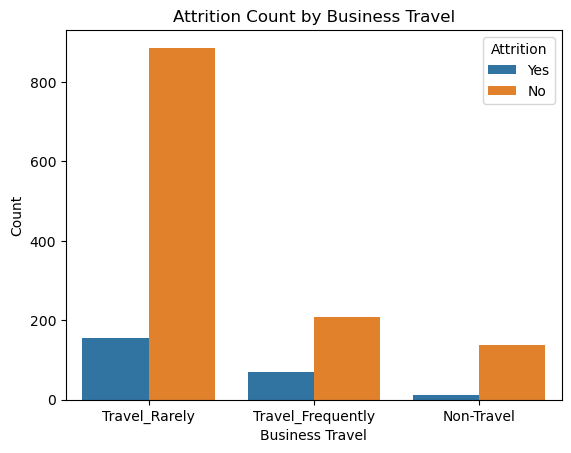

BusinessTravel Attrition  Percentage
0         Non-Travel        No   92.000000
1         Non-Travel       Yes    8.000000
2  Travel_Frequently        No   75.090253
3  Travel_Frequently       Yes   24.909747
4      Travel_Rarely        No   85.043145
5      Travel_Rarely       Yes   14.956855

In [8]:
#Shows the Attrition Count by Business Travel

# Plot the attrition count by business travel
sns.countplot(data=df, x='BusinessTravel', hue='Attrition')
plt.xlabel('Business Travel')
plt.ylabel('Count')
plt.title('Attrition Count by Business Travel')

plt.show()

attrition_percentage = df.groupby(['BusinessTravel', 'Attrition']).size() / df.groupby('BusinessTravel').size() * 100
attrition_percentage = attrition_percentage.reset_index(name='Percentage')
attrition_percentage

<a id="inc"></a>
### Monthly income per Department and Role

Monthly income varies across different departments and roles within the organization. Managers, across all departments, tend to have similar wages compared to other roles. However, it is evident that managers in the HR department earn more than their counterparts in the R&D and Sales departments. In terms of income, this managerial role can only be compared to that of research directors.

On the other hand, the lowest-paying position is that of a research scientist in the R&D department. Sales representatives also have relatively lower wages, but there are quite a few outliers in this category. These outliers can earn even more than some sales executives, indicating that a portion of the wage in sales is performance-dependent.

When considering attrition rates, it is apparent that employees who are paid higher wages tend to be less likely to leave the organization. This suggests that higher income serves as a motivator for employee retention.

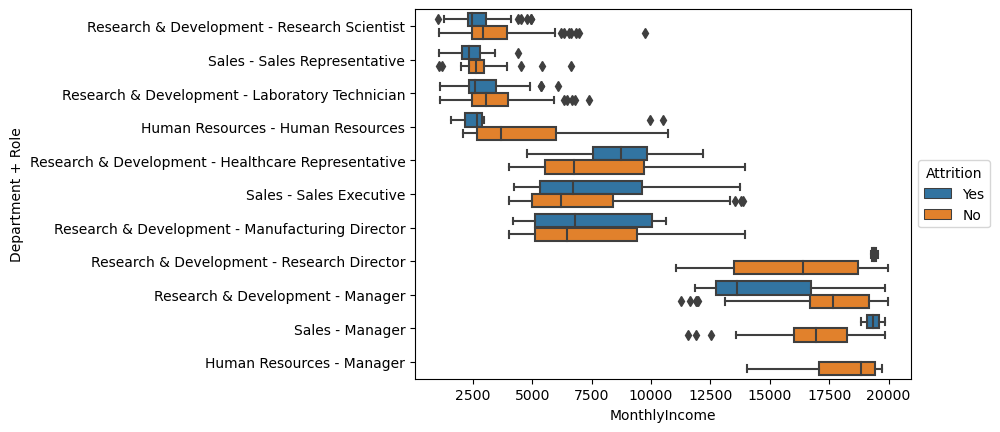

In [9]:
#Analyzes the monthly income per department and role

df2=df
# Create a new column combining Department and JobRole
df2['Department + Role'] = df['Department'] + " - " + df['JobRole']

# Sort the DataFrame by MonthlyIncome
df_sorted = df.sort_values('MonthlyIncome')

# Get the ordered unique values of Department + Role
ordered_categories = df_sorted['Department + Role'].unique()

# Create the boxplot with ordered categories
sns.boxplot(data=df, y='Department + Role', x="MonthlyIncome", hue="Attrition", dodge=True, order=ordered_categories)

# Adjust the legend position
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Attrition")

# Display the plot
plt.show()

<a id="cib"></a>
## Class Imbalance
The dataset exhibits a significant class imbalance, favoring employees who have churned. To address this, two approaches can be considered: oversampling and undersampling.

-Oversampling: Creating additional observations for the minority class to balance the dataset. It improves representation and helps the model capture nuanced patterns. However, it may introduce duplication and overfitting risks.

-Undersampling: Removing observations from the majority class to achieve balance. It reduces dominance but may lead to information loss and overlook important patterns.

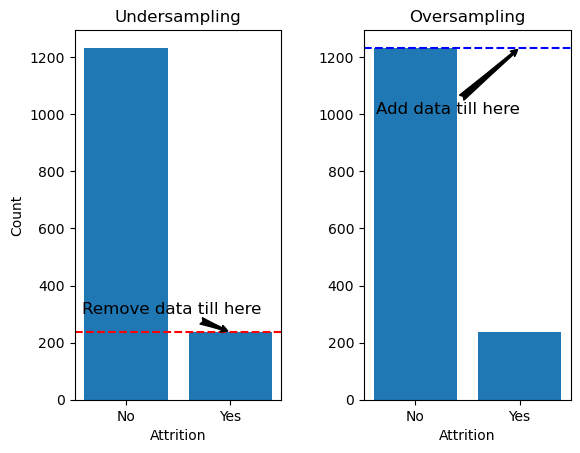

In [4]:
#Shows the class imbalance

#Import the dataset again
df2=pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")


# Count the levels in the "Attrition" column
attrition_counts = df2["Attrition"].value_counts()

# Create two subplots
plt.subplot(1, 2, 1)

# Create the plot showing undersampling
plt.bar(attrition_counts.index, attrition_counts.values)
# Add a horizontal line at y = 237
plt.axhline(y=237, color='r', linestyle='--')
# Annotate the horizontal line
plt.annotate('Remove data till here', xy=(1, 237), xytext=(1.3, 300),
             arrowprops=dict(facecolor='black', arrowstyle='fancy'),
             fontsize=12, ha='right')
# Set the plot title and labels
plt.title("Undersampling")
plt.xlabel("Attrition")
plt.ylabel("Count")

# Create the second subplot
plt.subplot(1, 2, 2)

# Create the plot showing oversampling
plt.bar(attrition_counts.index, attrition_counts.values)
# Add the horizontal line at y = 1233
plt.axhline(y=1233, color="b", linestyle="--")
# Annotate the horizontal line
plt.annotate("Add data till here", xy=(1, 1233), xytext=(1, 1000),
             arrowprops=dict(facecolor="black", arrowstyle="fancy"),
             fontsize=12, ha="right")
# Set the plot title and labels
plt.title("Oversampling")
plt.xlabel("Attrition")

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()


In [7]:
#pip install imblearn

<a id="vinc"></a>
### Variable Encoding

To encode the variables in the given context, we will use different encoding methods based on their characteristics. The variables "BusinessTravel" will be encoded using ordinal encoding, while the remaining variables ("Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "OverTime") will be encoded using one-hot encoding(n-1).

For "BusinessTravel", which has an ordinal nature, we will assign the values as follows: 0 for "Non-Travel", 1 for "Travel-Rarely", and 2 for "Travel-Frequently". This encoding reflects the increasing level of travel frequency.

On the other hand, the remaining variables do not have a natural ordering or hierarchy. Therefore, we will use one-hot encoding to represent each category as a separate binary column. Each category within these variables will be transformed into a binary column, where a value of 1 indicates the presence of that category, and 0 indicates its absence.

Finally, Attrition, the dependent variable will be encoded as being 1 if "Yes" or 0 if "No". Yes stands for the employee leaving the company.

By employing these encoding techniques, we can capture the relevant information from the categorical variables in a format suitable for further analysis or modeling.

In [8]:
#Preps the variable for analysis

# Create ordinal mapping for "BusinessTravel" column
ordinal_mapping = {
    "Non-Travel": 0,
    "Travel_Rarely": 1,
    "Travel_Frequently": 2
}

# Perform ordinal encoding for "BusinessTravel"
df['BusinessTravel'] = df['BusinessTravel'].map(ordinal_mapping)
df['BusinessTravel'] = df['BusinessTravel'].astype(int)

# Perform one-hot encoding
encoded_df = pd.get_dummies(df, columns=['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'], drop_first=True)

# Convert "Attrition" column to string data type
encoded_df['Attrition'] = encoded_df['Attrition'].astype(str)

# Encode "Attrition" variable
encoded_df['Attrition'] = encoded_df['Attrition'].map({'Yes': 1, 'No': 0})

# View the encoded dataframe
encoded_df.dtypes
encoded_df["Department + Role"]
encoded_df.drop("Department + Role", axis=1, inplace=True)
#print(encoded_df.head())


<a id="tts"></a>
### Train-test split

Prior to any analysis a train test split will be completed. This will be stratified to make sure that the dependent variable is properly sampled.

In [9]:
#Stratified Train test split
from sklearn.model_selection import train_test_split

y=encoded_df["Attrition"]
y = y.astype(int)


X = encoded_df.drop(columns=["Attrition"])
#X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())


0    986
1    190
Name: Attrition, dtype: int64
0    247
1     47
Name: Attrition, dtype: int64


For visualization purposes a new dataframe is created(Vdf). This dataframe will be the merged version of the dependent and independent variables training set. It will be used to create the undersampled/oversampled variants and as a base, comparing the datasets.

In [10]:
#Scales and resamples the dataset
combined_train = pd.concat([X_train, y_train], axis=1)


def run_sampling_options(dataset):
    X = dataset.iloc[:, :-1].values.astype(np.float32)
    y = dataset.iloc[:, -1].values.astype(np.float32)

    # Apply feature scaling to X
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    samplers = {
        'RandomOverSampler': RandomOverSampler(),
        'SMOTE': SMOTE(),
        'RandomUnderSampler': RandomUnderSampler(),
        'TomekLinks': TomekLinks(),
        'SMOTEENN': SMOTEENN(),
        "Cluster Centroids": ClusterCentroids(),
        "NearMiss": NearMiss(),
        "ADASYN": ADASYN(),
        "SMOTE-Tomek": SMOTETomek(),
        "Edited Nearest Neighbors": EditedNearestNeighbours()
    }

    resampled_datasets = {}
    for sampler_name, sampler in samplers.items():
        X_resampled, y_resampled = sampler.fit_resample(X, y)
        resampled_datasets[sampler_name] = (X_resampled, y_resampled)

    # Add original dataset to resampled datasets
    resampled_datasets['Original'] = (X, y)

    return resampled_datasets

resampled_datasets = run_sampling_options(combined_train)


/home/siki/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<a id="rsviz"></a>
### Resampling visualization
In this section of the notebook, we will explore different resampling techniques and explain their functionality using visualizations. Each resampler will be compared to the original dataset, highlighting the class distribution. The charts presented below demonstrate the class distribution for each sampling method.

There are three types of sampling techniques in the context of over and undersampling. The first is undersampling, which involves removing data points. The second is oversampling, where additional observations are added. Lastly, there are techniques that combine both undersampling and oversampling.

In this section, we will examine each resampled dataset individually and provide an explanation of how each algorithm works. Although the variables displayed are arbitrary, the details of the monthly rate and monthly income variables showcase the resampling methods effectively.

<a id="RO"></a>
###  The Random Oversampler
The random oversampler first finds out which class is imbalanced. After finding the imbalaced class, it calculates how imbalanced it is. Then it uses that ratio to figure out how many points need to be sampled. Finally, it samples them with replacement. 
The negative of this sampling technique is that it can foster overfitting.
In the visualizations below notice how in the random oversampler some points have less transparency. That is because the transparency of the points decreases if there are more plotted at the same location, showing the sampling with replacement feature. 

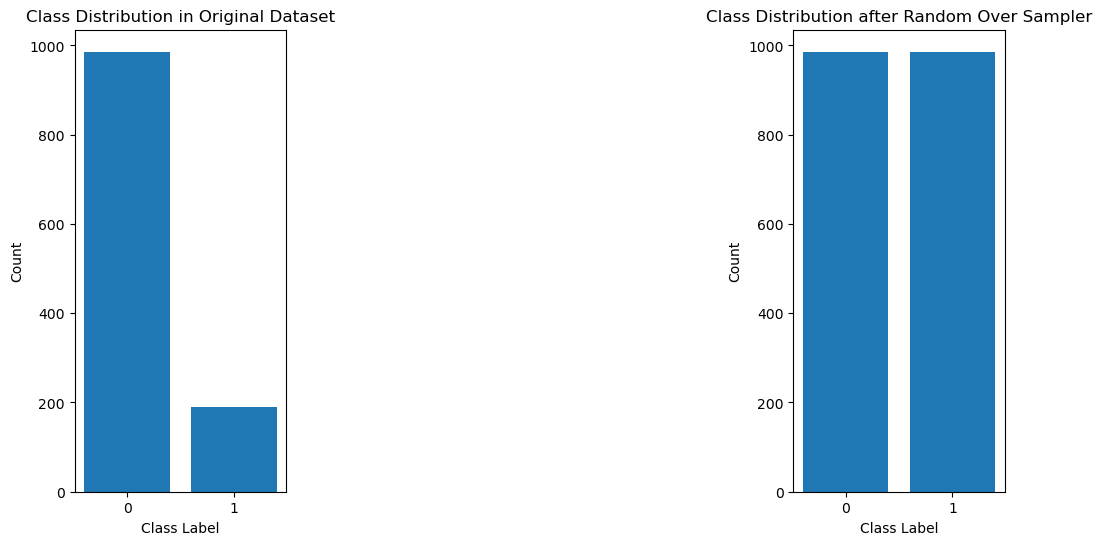

In [11]:
#Shows the class distribution of the original dataset and the one made by the RandomOverSampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['RandomOverSampler'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after Random Over Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


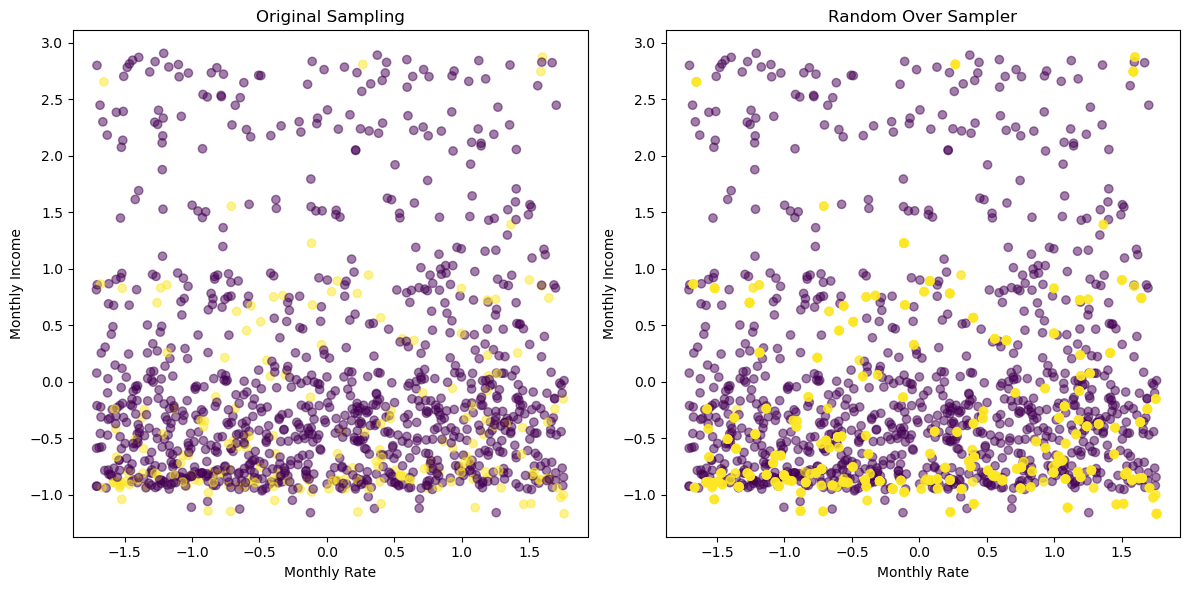

In [12]:
#Shows the effect the Random Over Sampler has on the observations
#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
X_resampled, y_resampled = resampled_datasets['Original']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Random Over Sampler
X_resampled, y_resampled = resampled_datasets['RandomOverSampler']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Random Over Sampler')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()

<a id="RU"></a>
### The Random Undersampler
The random undersampler operates in contrast to the random oversampler. It identifies the majority class, determines the desired number of instances based on the minority class, and randomly eliminates observations from the majority class until that target number is achieved.

However, one notable drawback is the increased likelihood of losing important information during this process.

In the visualization below, you can observe the diminishing number of purple dots, which represent instances from the majority class. This reduction highlights the effect of random undersampling on the class distribution.

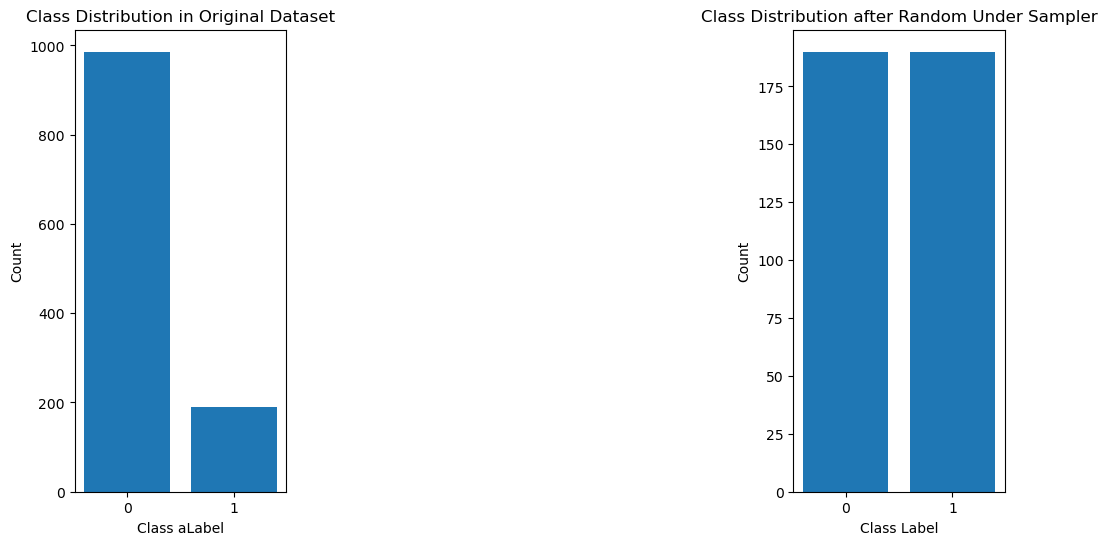

In [13]:
#Shows the class distribution of the original dataset and the one made by the RandomUnderSampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['RandomUnderSampler'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after Random Under Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


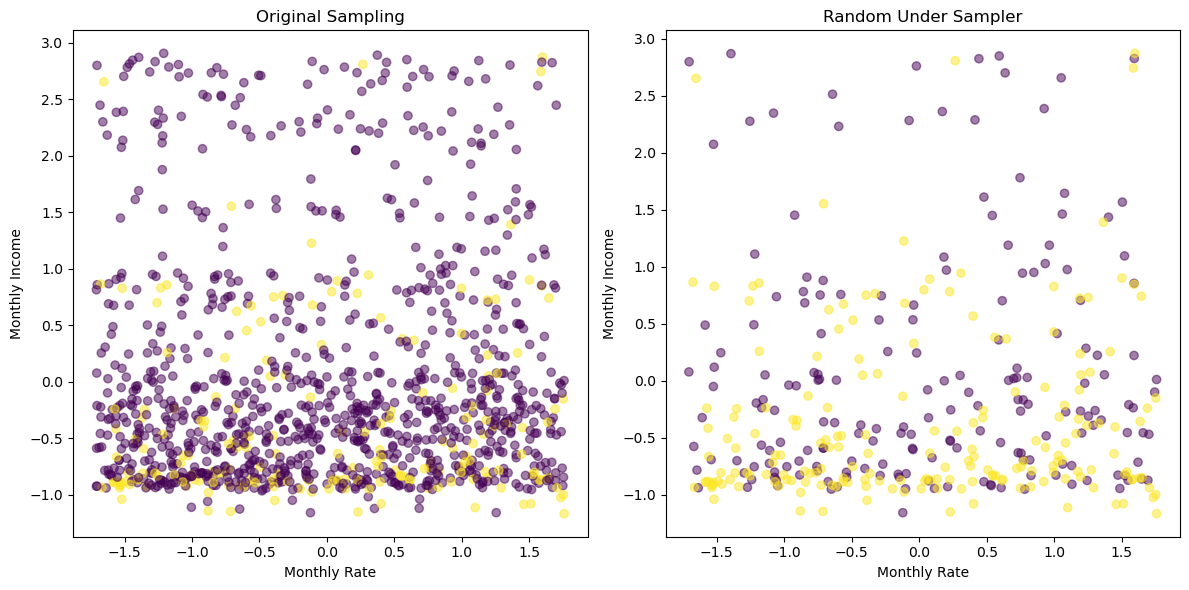

In [14]:
#Shows the effect the Random Under Sampler has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]



##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['RandomUnderSampler']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Random Under Sampler')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()

<a id="ADA"></a>
### ADASYN

ADASYN is an adaptive oversampling technique that addresses class imbalance by generating synthetic samples for the minority class. It focuses on the sparser regions of the feature space where the minority class is underrepresented. It calculates the imbalance ratio and determines the number of synthetic samples to generate based on it. ADASYN identifies the nearest neighbors of each minority class sample and assigns higher weights to those in sparser regions. It then generates synthetic samples by interpolating between the sample and its selected nearest neighbors. The original minority class samples are combined with the synthetic samples to create a more balanced dataset.

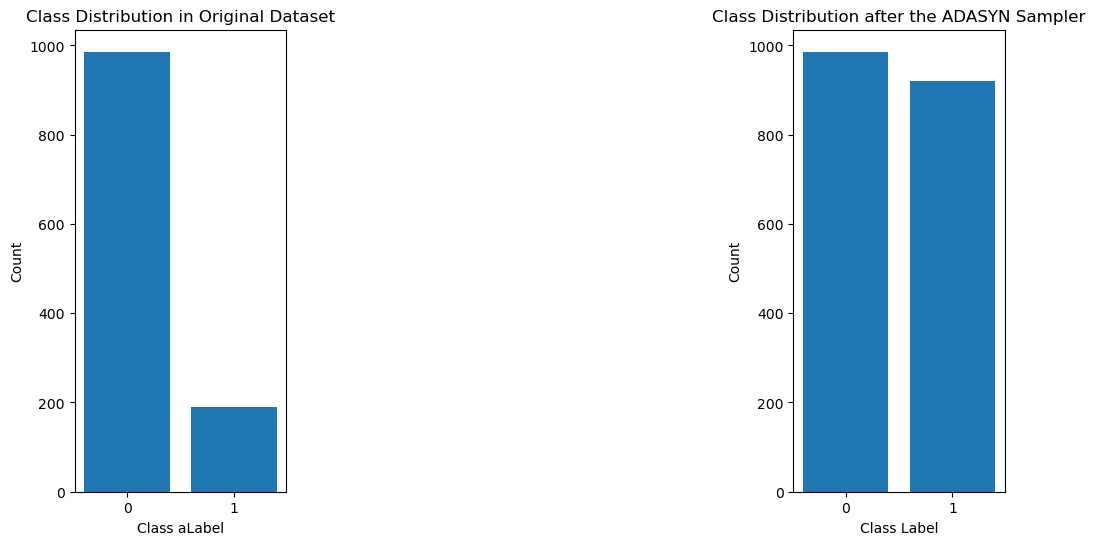

In [15]:
#Shows the class distribution of the original dataset and the one made by the ADASYN Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['ADASYN'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the ADASYN Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


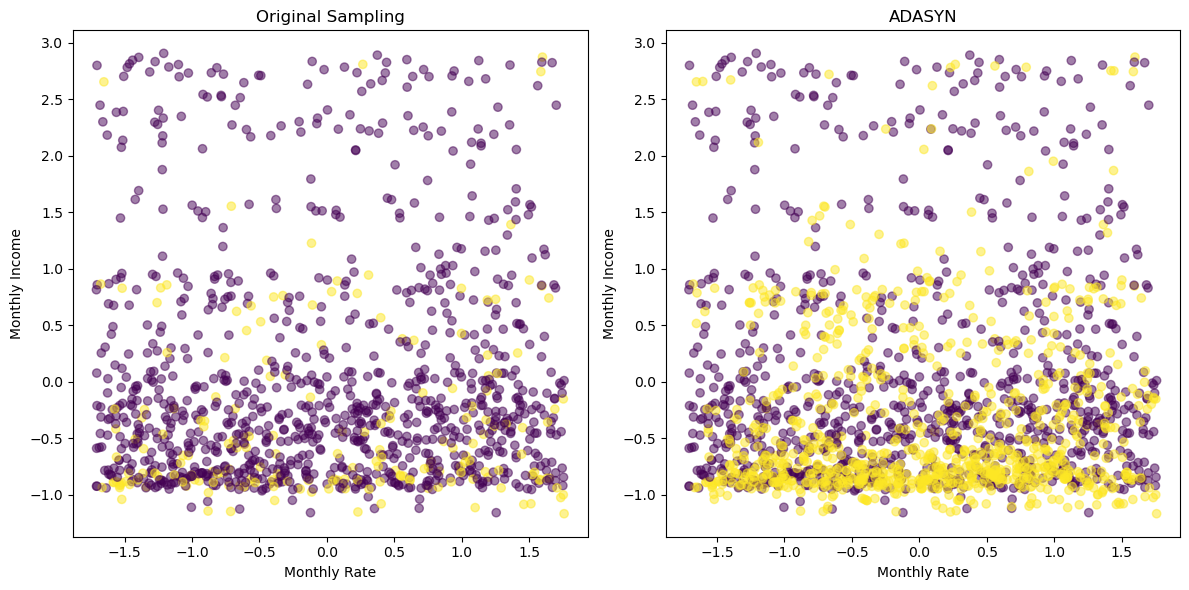

In [16]:
#Shows the effect ADASYN has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]



##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['ADASYN']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'ADASYN')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()

<a id="SMOTE"></a>
### SMOTE (Synthetic Minority Oversampling technique)

SMOTE is an oversampling mSMOTE (Synthetic Minority Over-sampling Technique) is an oversampling method that employs the concept of K-nearest neighbors to generate synthetic samples. The process begins by identifying the minority class within the dataset. From this minority class, a random observation is selected as a reference point.

Next, based on a specified value of K, which represents the number of neighbors to consider, the algorithm identifies the K-nearest neighbors of the reference point.

For each neighbor, the algorithm calculates the feature differences between the reference point and the neighbor. The features of the original observation are then multiplied by these feature differences, and a random number between 0 and 1 is added to further diversify the synthetic sample.

These synthetic samples, being creations that do not exist in the original dataset, help reduce the risk of overfitting.

In the visualization below, you can observe the synthetic samples generated by SMOTE, represented as new data points. By introducing these synthetic samples, the minority class is augmented, helping to balance the class distribution.

It's worth noting that the example uses default parameters, with K set to 5 and the distance metric being Euclidean.

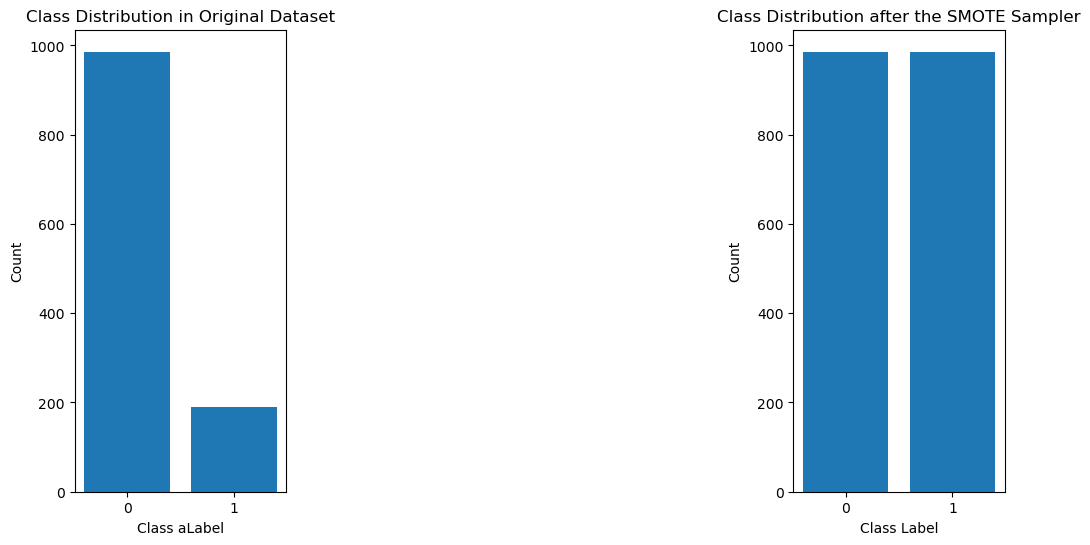

In [17]:
#Shows the class distribution of the original dataset and the one made by the SMOTE Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['SMOTE'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the SMOTE Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


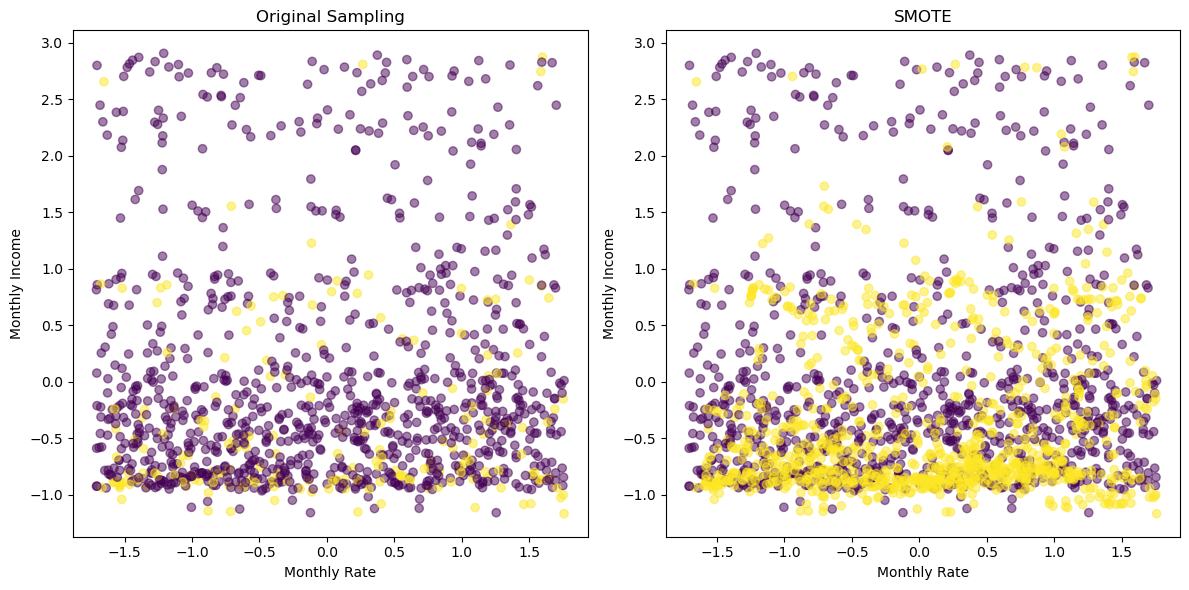

In [18]:
#Shows the effect the SMOTE Sampler has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]



##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['SMOTE']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'SMOTE')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()

<a id="ENN"></a>
### Edited Nearest neighbours

The Edited Nearest Neighbors (ENN) sampling technique is utilized in undersampling to eliminate noisy and potentially misclassified samples. It operates by utilizing the k-nearest neighbors algorithm for each majority class sample. The algorithm identifies the closest neighbors and, based on the majority class of those neighbors, decides whether to retain or remove the sample.

In the visualizations below, you can observe a red circle on the graphs, indicating a specific location where a member of the majority class was removed. This demonstrates the effect of ENN in removing certain majority class samples that are considered noisy or misclassified.

By selectively removing samples based on the class distribution of their nearest neighbors, ENN aims to enhance the overall quality of the dataset and improve classification performance.



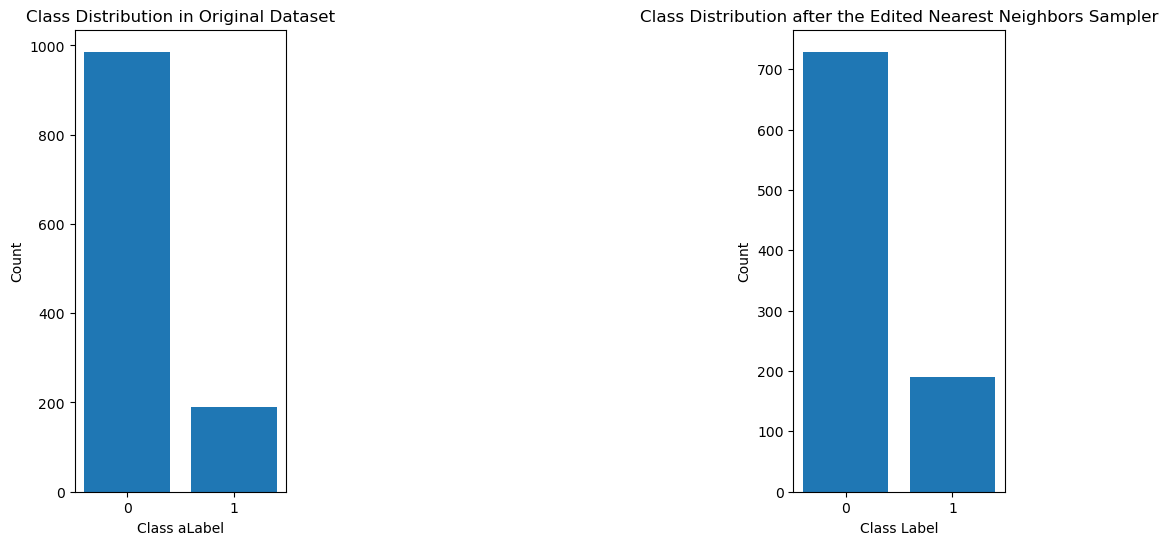

In [19]:
#Shows the class distribution of the original dataset and the one made by the Edited Nearest Neighbors Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['Edited Nearest Neighbors'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the Edited Nearest Neighbors Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


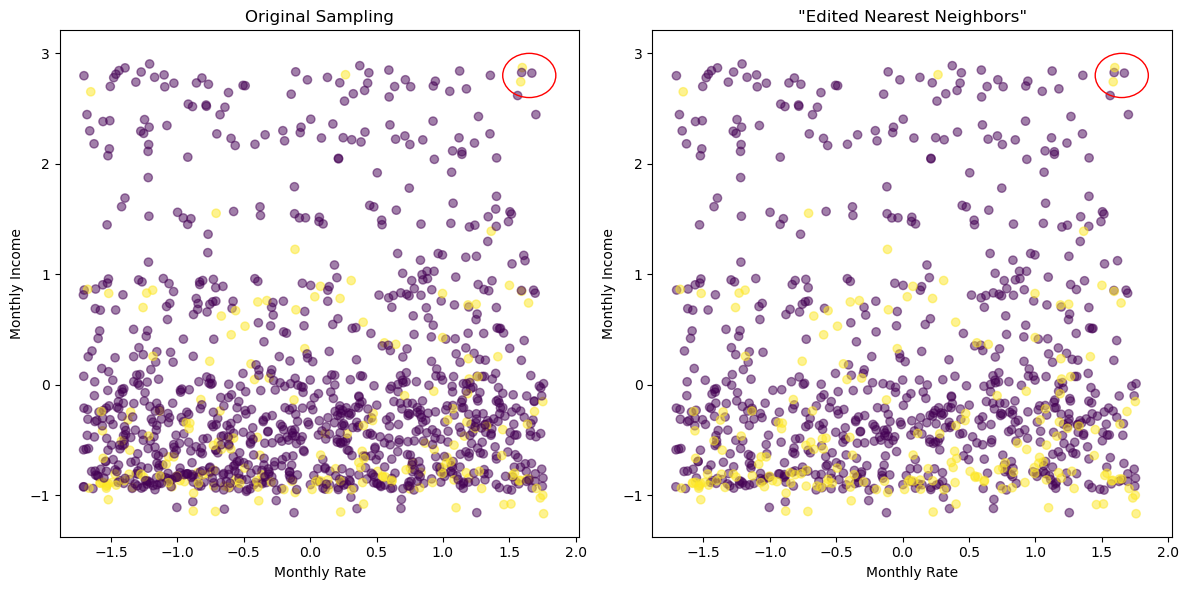

In [20]:
#Shows the effect the ENN Sampler has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]

# Add circle to the plot
circle = plt.Circle((1.65, 2.8), radius=0.2, color='red', fill=False)
plt.gca().add_patch(circle)


##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['Edited Nearest Neighbors']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'"Edited Nearest Neighbors"')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]

# Add circle to the plot
circle = plt.Circle((1.65, 2.8), radius=0.2, color='red', fill=False)
plt.gca().add_patch(circle)

plt.tight_layout()
plt.show()


<a id="SENN"></a>
### SMOTE ENN
The SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors) sampling technique combines the oversampling capabilities of SMOTE with the cleaning abilities of the EEN algorithm.

Firstly, SMOTE is used to generate synthetic samples, as explained earlier. These synthetic samples are created to address the class imbalance by expanding the minority class.

Subsequently, the EEN algorithm is applied to clean the dataset by removing noisy and potentially misclassified samples. For each synthetic sample generated by SMOTE, EEN evaluates its neighboring samples and decides whether to keep or remove it based on the majority class of its neighbors.

By combining SMOTE and EEN, the SMOTE-ENN technique aims to enhance the quality of the oversampled dataset by eliminating noisy and misleading synthetic samples. This helps improve classification performance and reduce the risk of overfitting.

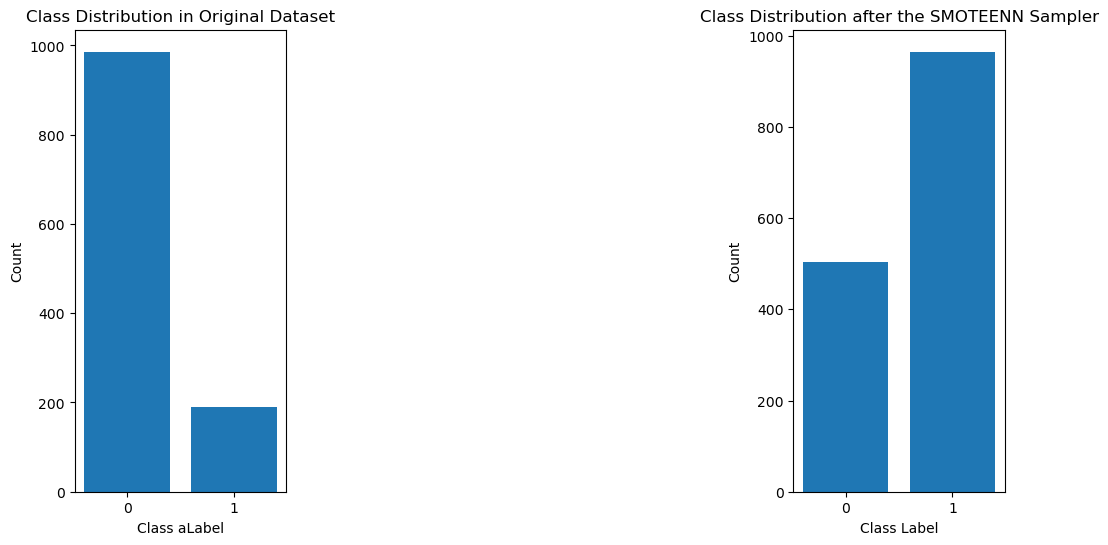

In [21]:
#Shows the class distribution of the original dataset and the one made by the SMOTEENN Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['SMOTEENN'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the SMOTEENN Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


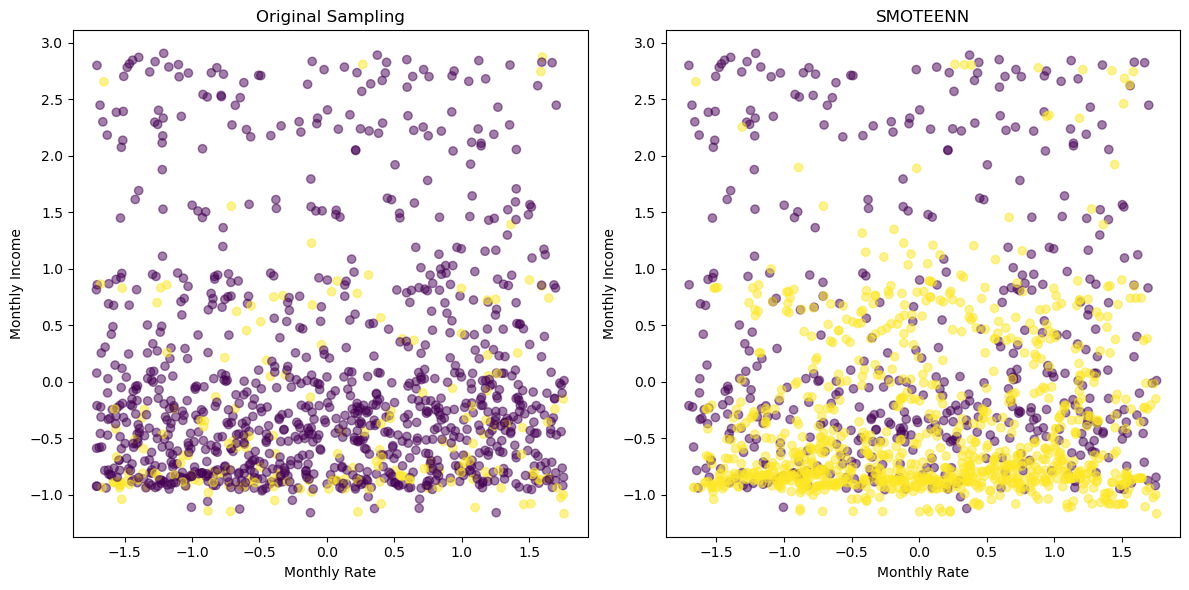

In [22]:
#Shows the effect the SMOTE ENN has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]



##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['SMOTEENN']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'SMOTEENN')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()


<a id="TOM"></a>
### Tomek Links

The Tomek links undersampling technique is employed to enhance the separation between classes in a dataset.

First, pairs are formed between each observation in the dataset. For each observation, the algorithm identifies its closest neighbor. If these two observations belong to different classes, they are considered Tomek linked.

Tomek linked pairs are subsequently removed from the dataset, aiming to eliminate instances that reside on the boundaries or overlap between classes. This process helps to improve the distinction and separability of the classes.

In the visualization below, you can observe a red circle indicating a removed observation. This highlights the effect of the Tomek links undersampling technique, where instances identified as Tomek linked are eliminated to promote clearer class separation.



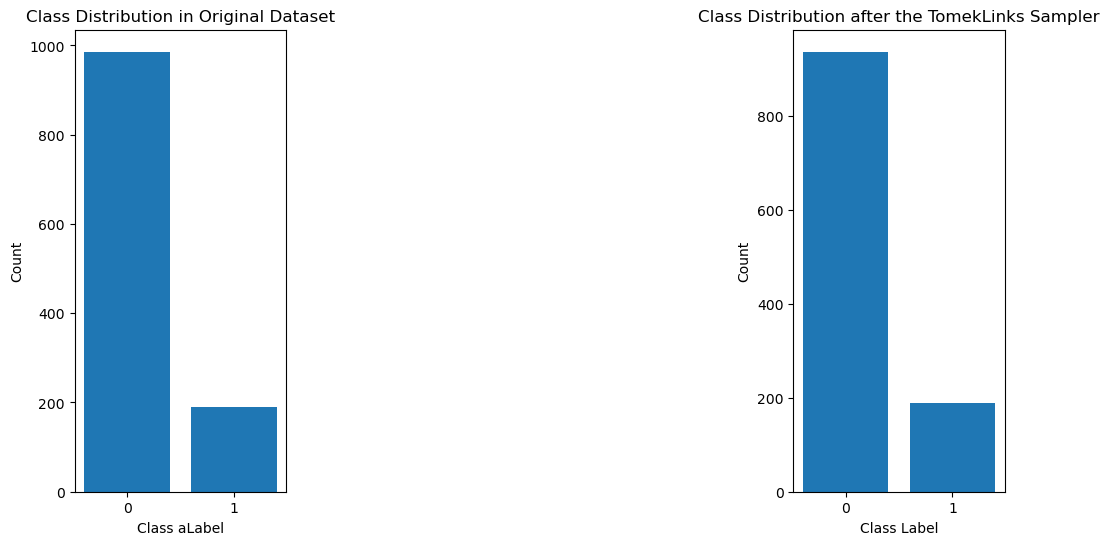

In [23]:
#Shows the class distribution of the original dataset and the one made by the TomekLinks Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['TomekLinks'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the TomekLinks Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


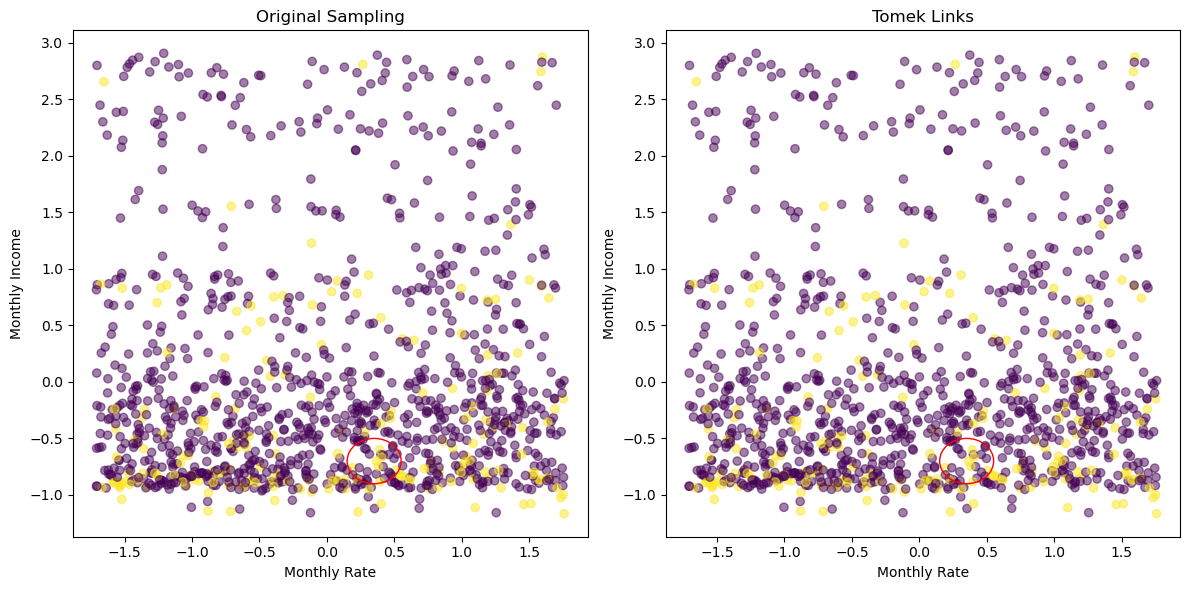

In [24]:
#Shows the effect the Tomek links have on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]

# Add circle to the plot
circle = plt.Circle((0.35, -0.7), radius=0.2, color='red', fill=False)
plt.gca().add_patch(circle)


##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['TomekLinks']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Tomek Links')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]

# Add circle to the plot
circle = plt.Circle((0.35, -0.7), radius=0.2, color='red', fill=False)
plt.gca().add_patch(circle)

plt.tight_layout()
plt.show()


<a id="STOM"></a>
### SMOTE-Tomek
The SMOTE-Tomek technique combines the previously mentioned SMOTE algorithm with Tomek links to address class imbalance.

Firstly, Tomek links are used to enhance the separation between classes by identifying and removing pairs of observations that are Tomek linked. This step aims to increase the distinctiveness and separability of the classes.

After applying the Tomek links undersampling, the SMOTE algorithm is utilized to generate synthetic samples for the minority class. By synthesizing new data points, SMOTE helps balance the class distribution while preserving the information inherent in the minority class.

However, it's important to note that excessive generation of synthetic samples can lead to overfitting, where the model becomes overly tailored to the training data. Thus, it is crucial to strike a balance and carefully control the number of synthetic samples generated.

By combining the strengths of both the SMOTE and Tomek links techniques, SMOTE-Tomek aims to achieve a balanced class distribution while retaining the relevant information from the minority class.

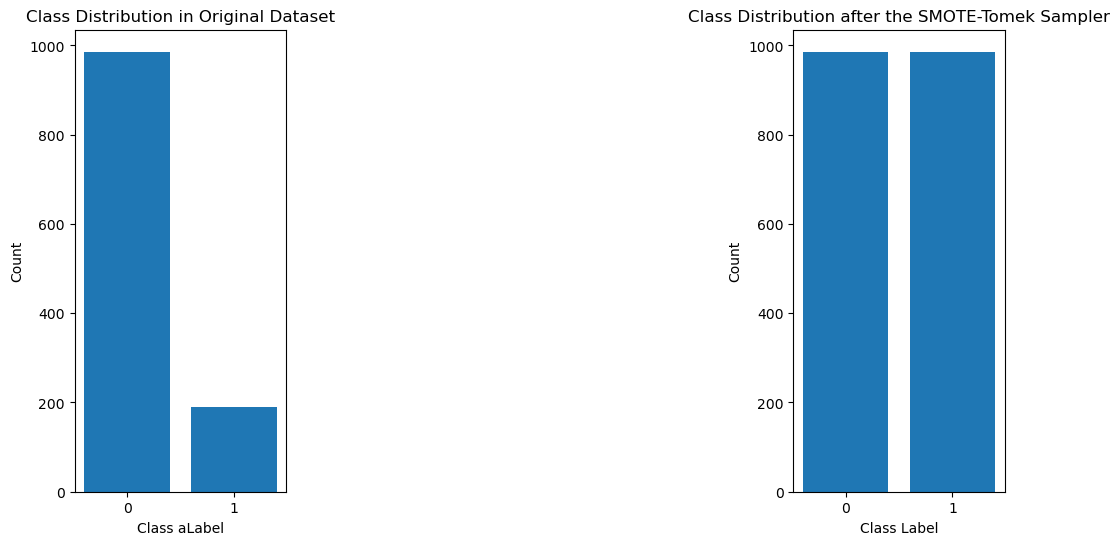

In [25]:
#Shows the class distribution of the original dataset and the one made by the SMOTE-Tomek Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['SMOTE-Tomek'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the SMOTE-Tomek Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


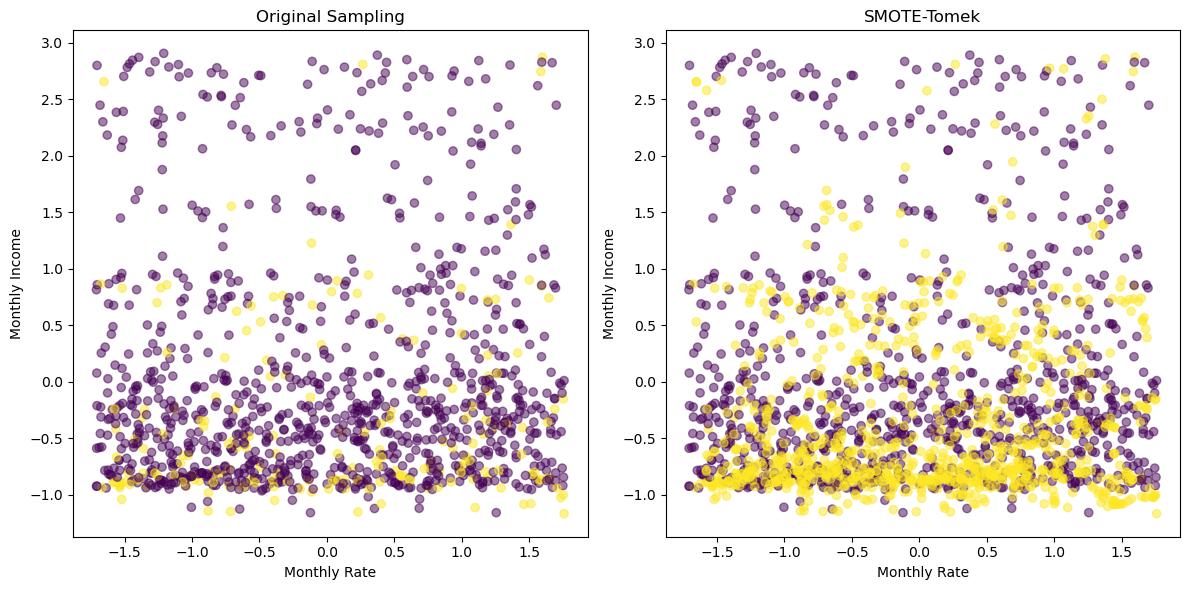

In [26]:
#Shows the effect the SMOTE-Tomek Sampler has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]



##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['SMOTE-Tomek']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'SMOTE-Tomek')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()


<a id="CC"></a>
### Cluster Centroids

The Cluster Centroids algorithm is an undersampling technique utilized in imbalanced classification problems. Its primary goal is to address the class imbalance by removing samples from the majority class while preserving the distribution and characteristics of the minority class.

The algorithm achieves this by identifying cluster centroids, which represent representative points within clusters formed by both minority and majority class samples. These cluster centroids serve as prototypes for the minority class.

Subsequently, for each majority class sample, the algorithm calculates its proximity to the cluster centroids. Samples that are closer to the cluster centroids are considered less representative of the majority class and are selectively removed.

By removing majority class samples based on their proximity to cluster centroids, the Cluster Centroids algorithm aims to create a more balanced dataset that retains the essential characteristics of the minority class. This helps to mitigate the class imbalance issue and can improve the performance of classification models.

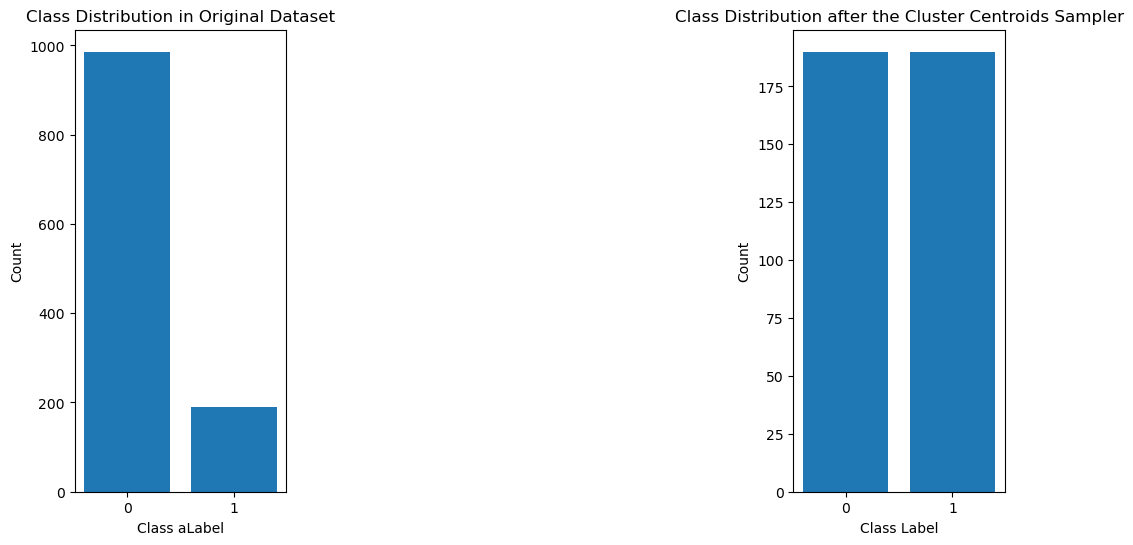

In [27]:
#Shows the class distribution of the original dataset and the one made by the Cluster Centroids Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['Cluster Centroids'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the Cluster Centroids Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


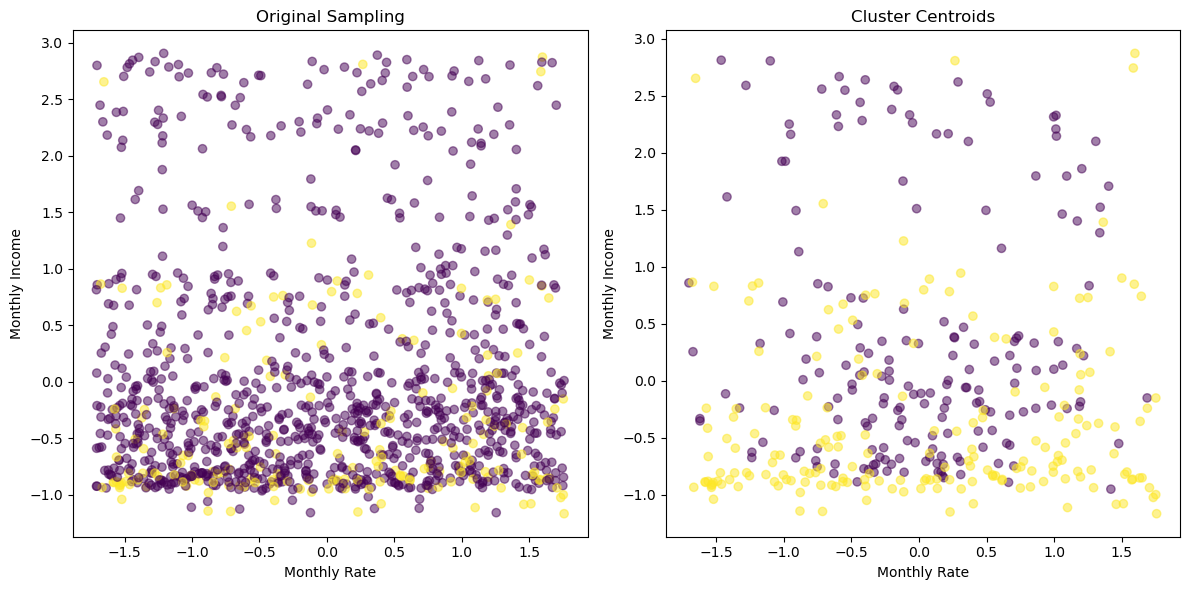

In [28]:
#Shows the effect the Cluster Centroids Sampler has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]



##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['Cluster Centroids']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Cluster Centroids')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()


<a id="NM"></a>
### Near miss
There are three variants of the near miss undersampling technique but the goal in all three is to address class imbalance in the areas nearest to the minority class.

NearMiss-1: This variant calculates the average distance from each minority class sample to its k nearest neighbors from the majority class. It aims to keep the minority class samples that are closest to the majority class samples, thereby retaining the most representative members of the minority class.

NearMiss-2: Similar to NearMiss-1, NearMiss-2 also calculates the average distance to the k nearest neighbors from the majority class for each minority class sample. However, it takes the opposite approach by selecting the minority class samples that are furthest away from the majority class samples. This variant focuses on keeping the minority class samples that are least similar to the majority class samples.

NearMiss-3: NearMiss-3 takes a balanced approach by considering both the nearest and furthest minority class samples. It aims to retain a balance between the two by removing the minority class samples that are in the middle. This variant seeks to address the class imbalance by selectively removing the minority class samples that are neither too close nor too far from the majority class samples.

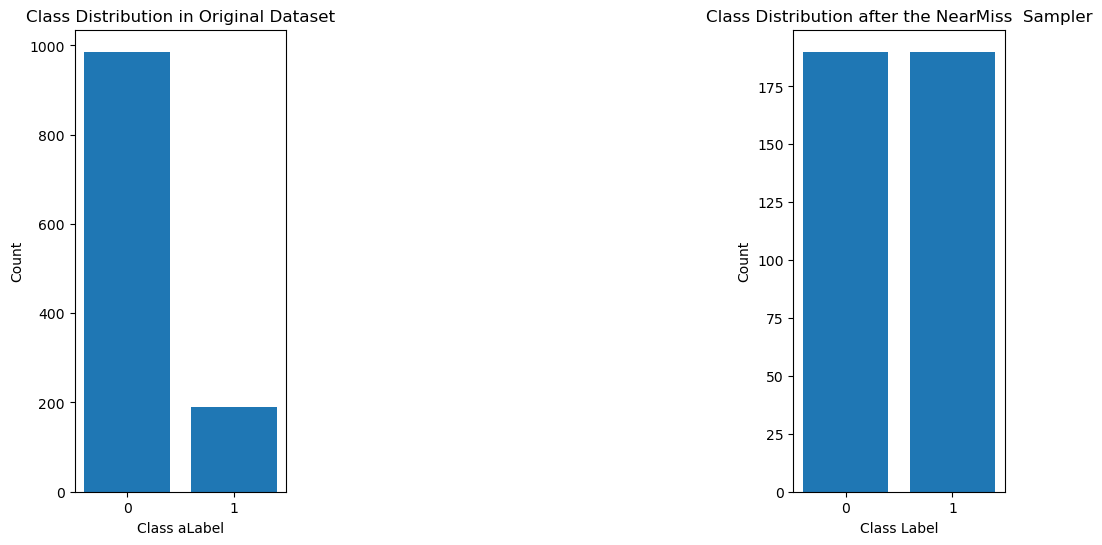

In [29]:
#Shows the class distribution of the original dataset and the one made by the NearMiss Sampler 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

# Count the occurrences of each class in the original dataset
class_counts_original = np.bincount(resampled_datasets['Original'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_original)
plt.xticks(class_labels)
plt.xlabel('Class aLabel')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

# Plot the bar chart of class distribution in the resampled dataset
class_counts_resampled = np.bincount(resampled_datasets['NearMiss'][1].astype(int))
class_labels = np.arange(len(class_counts_original))
plt.bar(class_labels, class_counts_resampled)
plt.xticks(class_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(f'Class Distribution after the NearMiss  Sampler')
plt.subplots_adjust(wspace=2.4)
plt.show()


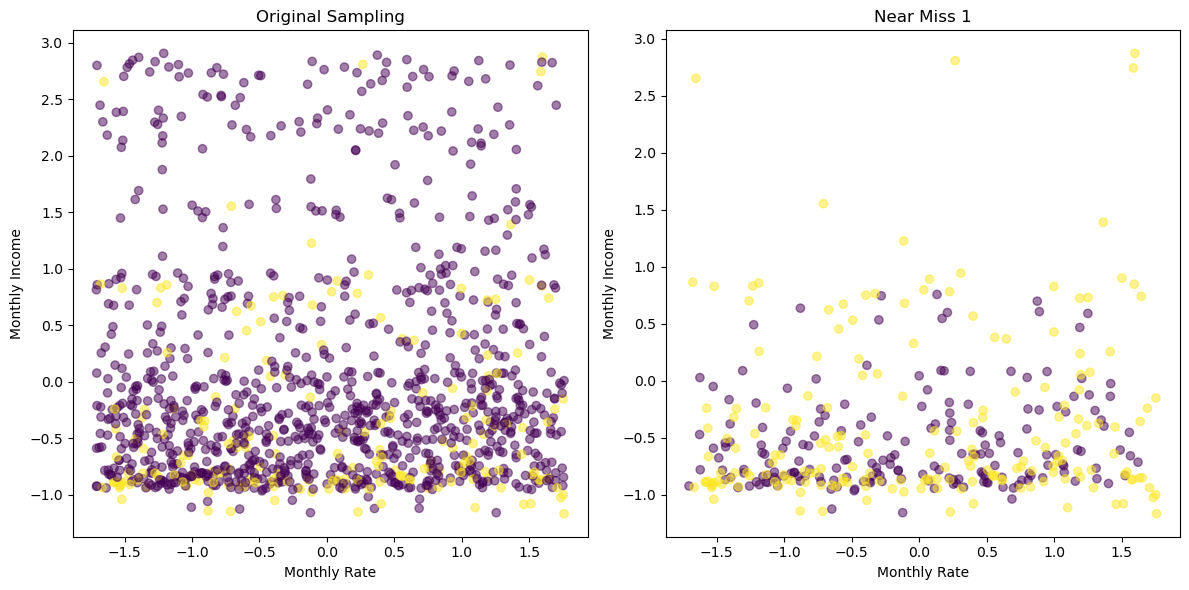

In [30]:
#Shows the effect the Near Miss 1 Sampler has on the observations

#Figure size
plt.figure(figsize=(12, 6))

monthly_rate_idx = 11  # The index of the "MonthlyRate" variable
monthly_income_idx = 10  # The index of the "HourlyRate" variable

X_resampled, y_resampled = resampled_datasets['Original']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1

##First plot

# Create a scatter plot
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Original Sampling')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]



##Second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 1

#Scatterplot for Tomek
X_resampled, y_resampled = resampled_datasets['NearMiss']
plt.scatter(x=X_resampled[:, monthly_rate_idx], y=X_resampled[:, monthly_income_idx], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title(f'Near Miss 1')
plt.xlabel('Monthly Rate')
plt.ylabel('Monthly Income')

# Add a legend for the class labels
unique_classes = np.unique(y)
class_labels = ['Class ' + str(cls) for cls in unique_classes]


plt.tight_layout()
plt.show()


<a id="MBE"></a>
## Model Building and Evaluation


In [31]:
#The X_train was scaled using the Standard Scaler and as such, the X_test needs to be scaled too. 
#These sets were scaled independently so as to minimize data leakage
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

<a id="CV"></a>
### Estimator(s) and cross validation
The code below performs model evaluation, hyperparameter tuning using grid search and computes the accuracy, precision, recall, and the auc score for each model. Finally, it builds and tests a stacking classifier using the best hyperparameters of the built models. The stakcing classifier uses a linear regression to figure out which model to use in classification.
The models tested are the logistic regression, the random forest, KNN, and AdaBoost.

In [32]:
#Estimators


def evaluate_algorithms(resampled_datasets, x_test, y_test):
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(),
            'params': {
                'logisticregression__C': [0.1, 1, 10],  # Regularization parameter
                'logisticregression__penalty': ['l1', 'l2']  # Regularization type
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'params': {
                'randomforestclassifier__n_estimators': [50, 100, 200],
                'randomforestclassifier__max_depth': [None, 5, 10],
            }
        },
        'Support Vector Machine': {
            'model': SVC(probability=True),
            'params': {
                'svc__C': [0.1, 1, 10],
                'svc__gamma': [0.1, 0.01, 0.001],
            }
        },
        'K Nearest Neighbors': {
            'model': KNeighborsClassifier(),
            'params': {
                'kneighborsclassifier__n_neighbors': [3, 5, 7],
                'kneighborsclassifier__weights': ['uniform', 'distance'],
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'decisiontreeclassifier__max_depth': [None, 5, 10],
            }
        },
        'AdaBoost': {
            'model': AdaBoostClassifier(),
            'params': {
                'adaboostclassifier__n_estimators': [50, 100, 200],
            }
        }
    }

    results = {}  # Dictionary to store the auc score
    accuracy = {}  # Dictionary to store the accuracy scores
    precision = {}  # Dictionary to store the precision scores
    recall = {}  # Dictionary to store the recall scores
    grid_searches = {}  # Dictionary to store the grid search objects

    for sampler_name, (X_resampled, y_resampled) in resampled_datasets.items():
        sampler_results = {}  # The auc score
        sampler_accuracy = {}  # Dictionary to store the accuracy scores for the sampler
        sampler_precision = {}  # Dictionary to store the precision scores for the sampler
        sampler_recall = {}  # Dictionary to store the recall scores for the sampler
        sampler_grid_searches = {}  # Dictionary to store the grid search objects for the sampler

        for model_name, model_data in models.items():
            model = model_data['model']
            params = model_data['params']
            pipeline = make_pipeline(model)
            grid_search = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc', refit=True)
            grid_search.fit(X_resampled, y_resampled)
            y_pred = grid_search.predict(x_test)
            y_proba = grid_search.predict_proba(x_test)[:, 1]

            auc_score = roc_auc_score(y_test, y_proba)
            s_accuracy = accuracy_score(y_test, y_pred)
            s_precision = precision_score(y_test, y_pred)
            s_recall = recall_score(y_test, y_pred)

            sampler_results[model_name] = auc_score
            sampler_accuracy[model_name] = s_accuracy
            sampler_precision[model_name] = s_precision
            sampler_recall[model_name] = s_recall
            sampler_grid_searches[model_name] = grid_search

        estimators = [(model_name, grid_search.best_estimator_) for model_name, grid_search in sampler_grid_searches.items()]

        stacking_classifier = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression()
        )
        stacking_classifier.fit(X_resampled, y_resampled)

        y_pred_stacking = stacking_classifier.predict(x_test)
        y_proba_stacking = stacking_classifier.predict_proba(x_test)[:, 1]

        auc_score_stacking = roc_auc_score(y_test, y_proba_stacking)
        s_accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
        s_precision_stacking = precision_score(y_test, y_pred_stacking)
        s_recall_stacking = recall_score(y_test, y_pred_stacking)

        sampler_results['Stacking Classifier'] = auc_score_stacking
        sampler_accuracy['Stacking Classifier'] = s_accuracy_stacking
        sampler_precision['Stacking Classifier'] = s_precision_stacking
        sampler_recall['Stacking Classifier'] = s_recall_stacking

        results[sampler_name] = sampler_results
        accuracy[sampler_name] = sampler_accuracy
        precision[sampler_name] = sampler_precision
        recall[sampler_name] = sampler_recall
        grid_searches[sampler_name] = sampler_grid_searches

    return results, grid_searches, accuracy, precision, recall


<a id="ESTOUT"></a>
### Estimator output
The code provided calculates and outputs important metrics for evaluating imbalanced classification problems. These metrics include the AUC score, accuracy, precision, and recall. When dealing with imbalanced datasets, relying solely on accuracy can be misleading because it can be high even if the minority class is not well predicted. Therefore, considering precision, recall, and the AUC score becomes crucial.
Precision measures the accuracy of positive predictions, ensuring that predicted positives are relevant. It is the proportion of correctly predicted positive instances out of all predicted positives. Recall, on the other hand, measures the classifier's ability to capture positive instances effectively. It is the proportion of correctly predicted positive instances out of all actual positive instances. In imbalanced datasets, both precision and recall are important, especially for identifying and handling the minority class, which is often the class of interest.
The AUC score provides an overall evaluation of the classifier's performance by considering its ability to distinguish between the minority and majority classes across different decision thresholds. It takes into account both the true positive rate (recall) and the false positive rate. This score is advantageous for imbalanced problems as it assesses the classifier's ability to differentiate between classes, regardless of the specific threshold chosen.
By using these metrics together, the code offers a comprehensive evaluation framework for assessing the performance of imbalanced classification models. It helps identify potential issues in capturing the minority class and provides insights for model improvement or selection.

Please note that the errors below are expected(ie the lfbfs solver does not work with the l1 penalty but this was ran due to an artifact of grid search) 

In [33]:
#Obtain the outputs
results, searches, accuracy, precision, recall = evaluate_algorithms(resampled_datasets, x_test=X_test, y_test=y_test)


/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/siki/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

In [34]:
### Enhance dataframe
def enhance_output(inputed_df):
    # Create statistics row-wise
    inputed_df["MEAN"] = inputed_df.mean(axis=1)
    inputed_df["MAX"] = inputed_df.max(axis=1)
    inputed_df["MIN"] = inputed_df.min(axis=1)

    # Create statistics column-wise
    r_min = inputed_df.min(axis=0)
    r_max = inputed_df.max(axis=0)
    r_mean = inputed_df.mean(axis=0)
    statistics = pd.DataFrame({'MEAN': r_mean, 'MAX': r_max, 'MIN': r_min}).T
    # Append statistics row-wise to results2
    df_with_statistics = pd.concat([inputed_df, statistics])
    return(df_with_statistics)


<a id="AUC"></a>
### AUC evaluation

Observing the AUC only, the best model on average accross all of the resampling methods is the Logistic regression with the EEN sampling method. The worst classifier for this problem is a decision tree but as it is a really simple algorithm and a weak learner, that does not seem surprising. 
The largest result however is the AdaBoost algorithm combined with a Random Oversampler or an ENN. This does make sense as a Random oversampler or with a more clean version of it would make sure that the Adaboost does have a large enough supply of misclassified examples.


In [35]:
#auc  
results = pd.DataFrame(results)
auc=enhance_output(results)
display(auc)

RandomOverSampler     SMOTE  RandomUnderSampler  \
Logistic Regression              0.790077  0.806185            0.779223   
Random Forest                    0.788483  0.747825            0.774485   
Support Vector Machine           0.781377  0.756310            0.831855   
K Nearest Neighbors              0.665131  0.703592            0.763589   
Decision Tree                    0.638858  0.446593            0.629038   
AdaBoost                         0.745542  0.737962            0.750625   
Stacking Classifier              0.771126  0.782152            0.809717   
MEAN                             0.740085  0.711517            0.762647   
MAX                              0.790077  0.806185            0.831855   
MIN                              0.638858  0.446593            0.629038   

                        TomekLinks  SMOTEENN  Cluster Centroids  NearMiss  \
Logistic Regression       0.831424  0.798518           0.831682  0.726075   
Random Forest             0.799810  0.747007           0.743432  0.628392   
Support Vector Machine    0.836334  0.737531           0.797356  0.691274   
K Nearest Neighbors       0.719873  0.697778           0.742958  0.669438   
Decision Tree             0.665863  0.648290           0.658239  0.633732   
AdaBoost                  0.785942  0.759842           0.672840  0.676200   
Stacking Classifier       0.835386  0.749246           0.803256  0.681626   
MEAN                      0.782090  0.734030           0.749966  0.672391   
MAX                       0.836334  0.798518           0.831682  0.726075   
MIN                       0.665863  0.648290           0.658239  0.628392   

                          ADASYN  SMOTE-Tomek  Edited Nearest Neighbors  \
Logistic Regression     0.834783     0.798949                  0.820743   
Random Forest           0.766862     0.781850                  0.792919   
Support Vector Machine  0.752520     0.754845                  0.828495   
K Nearest Neighbors     0.698294     0.716858                  0.731243   
Decision Tree           0.514170     0.554010                  0.722198   
AdaBoost                0.738134     0.706521                  0.797571   
Stacking Classifier     0.677578     0.770867                  0.819020   
MEAN                    0.711763     0.726271                  0.787456   
MAX                     0.834783     0.798949                  0.828495   
MIN                     0.514170     0.554010                  0.722198   

                        Original      MEAN       MAX       MIN  
Logistic Regression     0.816952  0.803146  0.834783  0.726075  
Random Forest           0.782238  0.759391  0.799810  0.628392  
Support Vector Machine  0.839349  0.782477  0.839349  0.691274  
K Nearest Neighbors     0.697088  0.709622  0.763589  0.665131  
Decision Tree           0.715695  0.620608  0.722198  0.446593  
AdaBoost                0.755018  0.738745  0.797571  0.672840  
Stacking Classifier     0.831682  0.775605  0.835386  0.677578  
MEAN                    0.776860  0.741371  0.798955  0.643983  
MAX                     0.839349  0.803146  0.839349  0.726075  
MIN                     0.697088  0.620608  0.722198  0.446593

<a id="ACC"></a>
### Accuracy Evaluation
Several algorithms and sampling techniques were evaluated for their performance in terms of accuracy. Notable performers include logistic regression, random forest, and AdaBoost with various sampling techniques. Logistic regression achieved high accuracy with the Random Oversampler, SMOTE, and ADASYN techniques. Random forest demonstrated good accuracy with the Random Oversampler, SMOTE-Tomek, and Edited Nearest Neighbors techniques. AdaBoost performed well with the Random Oversampler, TomekLinks, and Edited Nearest Neighbors techniques. 
In terms of accuracy, the top performers are logistic regression with a Random Oversampler, random forest, and adaboost with the original dataset. It is expected that random forest and adaboost perform well with the original dataset since these algorithms are known to handle imbalanced data effectively.

In [36]:
#Accuracy evaluation
acc=pd.DataFrame(accuracy)
acc=enhance_output(acc)
display(acc)

RandomOverSampler     SMOTE  RandomUnderSampler  \
Logistic Regression              0.741497  0.772109            0.714286   
Random Forest                    0.846939  0.510204            0.738095   
Support Vector Machine           0.840136  0.843537            0.755102   
K Nearest Neighbors              0.680272  0.625850            0.724490   
Decision Tree                    0.812925  0.285714            0.639456   
AdaBoost                         0.782313  0.176871            0.707483   
Stacking Classifier              0.840136  0.846939            0.738095   
MEAN                             0.792031  0.580175            0.716715   
MAX                              0.846939  0.846939            0.755102   
MIN                              0.680272  0.176871            0.639456   

                        TomekLinks  SMOTEENN  Cluster Centroids  NearMiss  \
Logistic Regression       0.874150  0.639456           0.727891  0.571429   
Random Forest             0.850340  0.462585           0.391156  0.527211   
Support Vector Machine    0.857143  0.819728           0.602041  0.530612   
K Nearest Neighbors       0.860544  0.506803           0.857143  0.727891   
Decision Tree             0.806122  0.357143           0.503401  0.513605   
AdaBoost                  0.863946  0.241497           0.391156  0.520408   
Stacking Classifier       0.870748  0.802721           0.557823  0.503401   
MEAN                      0.854713  0.547133           0.575802  0.556365   
MAX                       0.874150  0.819728           0.857143  0.727891   
MIN                       0.806122  0.241497           0.391156  0.503401   

                          ADASYN  SMOTE-Tomek  Edited Nearest Neighbors  \
Logistic Regression     0.772109     0.758503                  0.826531   
Random Forest           0.534014     0.598639                  0.836735   
Support Vector Machine  0.843537     0.843537                  0.819728   
K Nearest Neighbors     0.608844     0.629252                  0.857143   
Decision Tree           0.183673     0.265306                  0.809524   
AdaBoost                0.255102     0.221088                  0.833333   
Stacking Classifier     0.840136     0.850340                  0.843537   
MEAN                    0.576774     0.595238                  0.832362   
MAX                     0.843537     0.850340                  0.857143   
MIN                     0.183673     0.221088                  0.809524   

                        Original      MEAN       MAX       MIN  
Logistic Regression     0.877551  0.752319  0.877551  0.571429  
Random Forest           0.850340  0.649660  0.850340  0.391156  
Support Vector Machine  0.867347  0.783859  0.867347  0.530612  
K Nearest Neighbors     0.860544  0.721707  0.860544  0.506803  
Decision Tree           0.809524  0.544218  0.812925  0.183673  
AdaBoost                0.846939  0.530921  0.863946  0.176871  
Stacking Classifier     0.874150  0.778912  0.874150  0.503401  
MEAN                    0.855199  0.680228  0.858115  0.409135  
MAX                     0.877551  0.783859  0.877551  0.571429  
MIN                     0.809524  0.530921  0.812925  0.176871

<a id="PCC"></a>
### Precision evaluation

The stacking classifier has the highest precision score possible. That means that this model correctly predicted all of the positives it predicted positively. 
A stacking classifier can be beneficial for improving precision by leveraging the strengths of multiple individual classifiers. It combines the predictions of multiple base classifiers and learns to make more accurate predictions by considering the collective knowledge of the individual models. This ensemble approach can enhance precision by reducing false positive predictions and improving the overall classification performance.
By combining the predictions of multiple base classifiers and training a meta-classifier on top of them, the stacking classifier can capture complex patterns and exploit the strengths of different models. This ensemble approach can lead to improved precision by leveraging the individual strengths of the base classifiers to make more accurate predictions, especially in cases where individual models may struggle to achieve high precision on their own.

In [37]:
# Precision evaluation
prec=pd.DataFrame(precision)
prec=enhance_output(prec)
display(prec)

RandomOverSampler     SMOTE  RandomUnderSampler  \
Logistic Regression              0.344086  0.386364            0.327103   
Random Forest                    0.562500  0.216374            0.340426   
Support Vector Machine           0.000000  1.000000            0.371134   
K Nearest Neighbors              0.257732  0.255814            0.339623   
Decision Tree                    0.409091  0.177866            0.252101   
AdaBoost                         0.360656  0.162630            0.310680   
Stacking Classifier              0.000000  1.000000            0.358491   
MEAN                             0.276295  0.457007            0.328508   
MAX                              0.562500  1.000000            0.371134   
MIN                              0.000000  0.162630            0.252101   

                        TomekLinks  SMOTEENN  Cluster Centroids  NearMiss  \
Logistic Regression       0.656250  0.284672           0.336634  0.241830   
Random Forest             0.600000  0.209424           0.202703  0.219512   
Support Vector Machine    0.692308  0.375000           0.266667  0.213836   
K Nearest Neighbors       0.687500  0.224719           0.631579  0.267606   
Decision Tree             0.391304  0.177273           0.217143  0.214286   
AdaBoost                  0.620690  0.171642           0.179612  0.223529   
Stacking Classifier       0.628571  0.351351           0.254438  0.210526   
MEAN                      0.610946  0.256297           0.298396  0.227304   
MAX                       0.692308  0.375000           0.631579  0.267606   
MIN                       0.391304  0.171642           0.179612  0.210526   

                          ADASYN  SMOTE-Tomek  Edited Nearest Neighbors  \
Logistic Regression     0.388889     0.360465                  0.464286   
Random Forest           0.232143     0.251748                  0.481481   
Support Vector Machine  1.000000     1.000000                  0.448276   
K Nearest Neighbors     0.242424     0.268657                  0.575758   
Decision Tree           0.163763     0.176245                  0.418182   
AdaBoost                0.174242     0.165441                  0.479167   
Stacking Classifier     0.500000     1.000000                  0.509434   
MEAN                    0.385923     0.460365                  0.482369   
MAX                     1.000000     1.000000                  0.575758   
MIN                     0.163763     0.165441                  0.418182   

                        Original      MEAN       MAX       MIN  
Logistic Regression     0.689655  0.407294  0.689655  0.241830  
Random Forest           0.666667  0.362089  0.666667  0.202703  
Support Vector Machine  0.900000  0.569747  1.000000  0.000000  
K Nearest Neighbors     0.800000  0.413765  0.800000  0.224719  
Decision Tree           0.363636  0.269172  0.418182  0.163763  
AdaBoost                0.533333  0.307420  0.620690  0.162630  
Stacking Classifier     0.678571  0.499217  1.000000  0.000000  
MEAN                    0.661695  0.404100  0.742170  0.142235  
MAX                     0.900000  0.569747  1.000000  0.241830  
MIN                     0.363636  0.269172  0.418182  0.000000

<a id="RCC"></a>
### Recall evaluation
Based on these observations, AdaBoost appears to have the highest overall performance, consistently achieving high accuracy values across various sampling techniques. Decision Tree also showed competitive performance, especially when combined with Random Forest and Stacking Classifier. 
The stacking classifier had low results on recall. Having a good result on precision and low on recall typically indicates that the classifier is conservative in its predictions and tends to be cautious in labeling instances as positive. 

In [38]:
# Recall evaluation
rec=pd.DataFrame(recall)
rec=enhance_output(rec)
display(rec)

RandomOverSampler     SMOTE  RandomUnderSampler  \
Logistic Regression              0.680851  0.723404            0.744681   
Random Forest                    0.191489  0.787234            0.680851   
Support Vector Machine           0.000000  0.021277            0.765957   
K Nearest Neighbors              0.531915  0.702128            0.765957   
Decision Tree                    0.382979  0.957447            0.638298   
AdaBoost                         0.468085  1.000000            0.680851   
Stacking Classifier              0.000000  0.042553            0.808511   
MEAN                             0.322188  0.604863            0.726444   
MAX                              0.680851  1.000000            0.808511   
MIN                              0.000000  0.021277            0.638298   

                        TomekLinks  SMOTEENN  Cluster Centroids  NearMiss  \
Logistic Regression       0.446809  0.829787           0.723404  0.787234   
Random Forest             0.191489  0.851064           0.957447  0.765957   
Support Vector Machine    0.191489  0.191489           0.851064  0.723404   
K Nearest Neighbors       0.234043  0.851064           0.255319  0.404255   
Decision Tree             0.382979  0.829787           0.808511  0.765957   
AdaBoost                  0.382979  0.978723           0.787234  0.808511   
Stacking Classifier       0.468085  0.276596           0.914894  0.765957   
MEAN                      0.328267  0.686930           0.756839  0.717325   
MAX                       0.468085  0.978723           0.957447  0.808511   
MIN                       0.191489  0.191489           0.255319  0.404255   

                          ADASYN  SMOTE-Tomek  Edited Nearest Neighbors  \
Logistic Regression     0.744681     0.659574                  0.553191   
Random Forest           0.829787     0.765957                  0.276596   
Support Vector Machine  0.021277     0.021277                  0.553191   
K Nearest Neighbors     0.680851     0.765957                  0.404255   
Decision Tree           1.000000     0.978723                  0.489362   
AdaBoost                0.978723     0.957447                  0.489362   
Stacking Classifier     0.042553     0.063830                  0.574468   
MEAN                    0.613982     0.601824                  0.477204   
MAX                     1.000000     0.978723                  0.574468   
MIN                     0.021277     0.021277                  0.276596   

                        Original      MEAN       MAX       MIN  
Logistic Regression     0.425532  0.665377  0.829787  0.425532  
Random Forest           0.127660  0.584139  0.957447  0.127660  
Support Vector Machine  0.191489  0.321083  0.851064  0.000000  
K Nearest Neighbors     0.170213  0.524178  0.851064  0.170213  
Decision Tree           0.255319  0.680851  1.000000  0.255319  
AdaBoost                0.340426  0.715667  1.000000  0.340426  
Stacking Classifier     0.404255  0.396518  0.914894  0.000000  
MEAN                    0.273556  0.555402  0.914894  0.188450  
MAX                     0.425532  0.715667  1.000000  0.425532  
MIN                     0.127660  0.321083  0.829787  0.000000

<a id="FIN"></a>
## Conclusion
To conclude, after evaluating various sampling methods, the Adaboost algorithm emerged as the top performer with the highest AUC. Among the different datasets used, both the tomek-links and the original (no-sampling) dataset consistently demonstrated superior accuracy for most models. When considering precision, the stacking classifier outperformed others when paired with the Random Oversampler and the original dataset. In terms of recall, SMOTE proved to be the most effective sampling method.

Taking all factors into account, the final decision is to employ the Adaboost algorithm with SMOTE sampling as the ultimate estimator.

In [39]:
# Access the best estimators for each model
best_estimators = {}
for sampler_name, sampler_grid_searches in searches.items():
    best_estimators[sampler_name] = {}
    for model_name, grid_search in sampler_grid_searches.items():
        best_estimators[sampler_name][model_name] = grid_search.best_estimator_

# Print the best estimators
for sampler_name, sampler_best_estimators in best_estimators.items():
    print(f"Sampler: {sampler_name}")
    for model_name, best_estimator in sampler_best_estimators.items():
        print(f"Model: {model_name}")
        print(best_estimator)
        print()


Sampler: RandomOverSampler
Model: Logistic Regression
Pipeline(steps=[('logisticregression', LogisticRegression(C=10))])

Model: Random Forest
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200))])

Model: Support Vector Machine
Pipeline(steps=[('svc', SVC(C=10, gamma=0.1, probability=True))])

Model: K Nearest Neighbors
Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])

Model: Decision Tree
Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier())])

Model: AdaBoost
Pipeline(steps=[('adaboostclassifier', AdaBoostClassifier(n_estimators=200))])

Sampler: SMOTE
Model: Logistic Regression
Pipeline(steps=[('logisticregression', LogisticRegression(C=1))])

Model: Random Forest
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200))])

Model: Support Vector Machine
Pipeline(steps=[('svc', SVC(C=10, gamma=0.1, probability

In [40]:
# Access the best estimator for adaboost with smote sampling
best_adaboost_smote = best_estimators['SMOTE']
best_adaboost_smote["AdaBoost"]

Pipeline(steps=[('adaboostclassifier', AdaBoostClassifier(n_estimators=100))])